# Import Statements

In [9]:
# For uploading and reading files
import json
# For managing data
import pandas as pd
import numpy as np
# For dealing with time
import calendar
import datetime
import pytz
# For plotting
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sea

py.sign_in('jtk5aw', 'pCLaCol9EY9zOxOmUDsU')
LOCAL_TZ = pytz.timezone('US/Eastern')

# Goodreads

### Oraganizing Data

In [11]:
df = pd.read_csv("goodreads_library_export.csv")
readOrNot = df["Exclusive Shelf"]
pages = df["Number of Pages"]
myRatings = df["My Rating"]

In [12]:
ratingsAndPages = np.stack((myRatings, pages))
ratingPageSums = [0] * 5
for i in range(len(ratingsAndPages[0])):
  if ratingsAndPages[0][i] != 0:
    ratingPageSums[int(ratingsAndPages[0][i]) - 1] += ratingsAndPages[1][i] 

###  Plotting Data

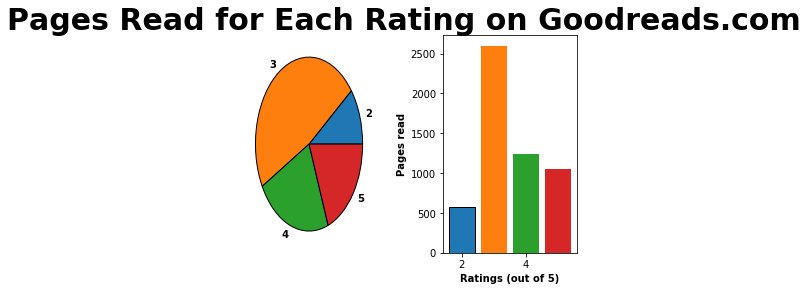

In [13]:
plt.figure()
plt.suptitle("Pages Read for Each Rating on Goodreads.com", fontsize='30', fontweight='bold', color='black', ha='center')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.pie(ratingPageSums[1:], textprops={'color': 'black', 'fontweight': 'bold'}, labels=["2", "3", "4", "5"], wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

plt.subplot(1,2,2)
plt.bar(np.arange(len(ratingPageSums[1:])) + 2, ratingPageSums[1:], align='center', color=['C0','C1','C2','C3'], edgecolor='black', linewidth='1')
plt.ylabel("Pages read", fontweight="bold")
plt.xlabel("Ratings (out of 5)", fontweight="bold")
plt.show()

# Instagram

### Organizing Likes Data

In [17]:
with open('_jacksonkennedy__20180910/likes.json') as jsonFile:
  likesJSON = json.load(jsonFile)
df2 = pd.DataFrame(likesJSON["media_likes"], columns=["Timestamp", "User"])
yearMap = {
    "2013": 0,
    "2014": 1,
    "2015": 2,
    "2016": 3,
    "2017": 4,
    "2018": 5
}

In [18]:
def assignColor(x):
  if x < 10: 
    return "#1874CD"
  elif x < 20:
    return "#EE0000"
  elif x < 30:
    return "#CD0000"
  else:
    return "#8B0000"

In [19]:
yearAndMonthSums = np.zeros((12,6))
likedUsers = {}
for i in range(len(df2["Timestamp"])):
  # Putting Likes into 2D array with rows = Months and columns = years
  month = int(df2["Timestamp"][i][5:7])
  year = yearMap[df2["Timestamp"][i][0:4]]
  yearAndMonthSums[month - 1][year] += 1 
  # User counts for october
  if year == 4 and (month == 10 or month == 11):
    likedUser = df2["User"][i]
    if likedUser in likedUsers:
      likedUsers[likedUser] += 1
    else: 
      likedUsers[likedUser] = 1
sortedLikedUsers = sorted(likedUsers.items(), key=(lambda x: x[1]))
# Creates List of Colors to be used by October Likes Bar chart
zippedSortedLikedUsers = zip(*sortedLikedUsers)
colors = [assignColor(i[1]) for i in sortedLikedUsers]

### Organizing Connections Data

In [35]:
with open('_jacksonkennedy__20180910/connections.json') as jsonFile:
  connectionsJSON = json.load(jsonFile)
followers = sorted(connectionsJSON["followers"].items(), key=(lambda x: x[1]))
followersUnzipped =  list(zip(*followers))
following = sorted(connectionsJSON["following"].items(), key=(lambda x: x[1]))
followingUnzipped = list(zip(*following))

In [39]:
# Each timestamp is an increase of one follower/followee so range is used
trace0 = go.Scatter(
    x = followersUnzipped[1],
    y = list(range(len(followersUnzipped[1]))),
    text = followersUnzipped[0],
    name = "Followers"
)

trace1 = go.Scatter(
    x = followingUnzipped[1],
    y = list(range(len(followersUnzipped[1]))),
    text = followingUnzipped[0],
    name = "Following"
)

#Title
figLayout = go.Layout(
    title = "<b>Followers/Following Count over Time</b>",
    titlefont = dict(
        size = 30,
        color = "black"
    ),
    xaxis = dict(
        title="Date",
        titlefont = dict(
            size = 20,
            color = "black"
        )
    ),
    yaxis = dict(
        title="Followers/Following Count",
        titlefont = dict(
            size = 20,
            color = "black"
        )
    )
)

# Data to be passed to iplot
traces = [trace0, trace1]

### Plots

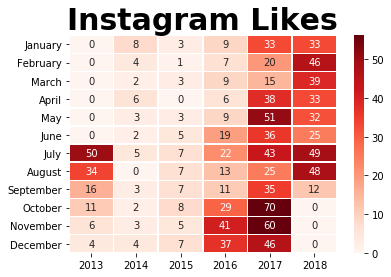

In [40]:
ynames = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
xnames = ["2013", "2014", "2015", "2016", "2017", "2018"]
ax = sea.heatmap(yearAndMonthSums, linewidths=0.5, yticklabels=ynames, xticklabels=xnames, cmap="Reds", robust=True, annot=True).set_title("Instagram Likes", ha="center", fontsize=30, fontweight="bold")

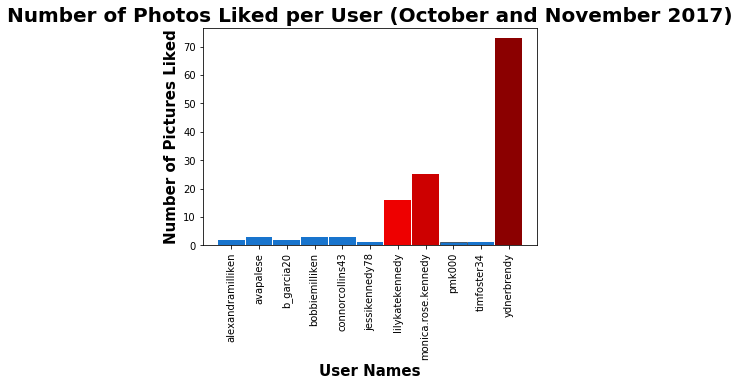

In [41]:
likedUserFrame = pd.DataFrame(sortedLikedUsers, columns=["User", "Count"])
ax = plt.bar(likedUserFrame["User"], likedUserFrame["Count"], width=.97, color=colors, edgecolor="black", linewidth=0.5)
a = plt.xticks(rotation='vertical')
a = plt.xlabel("User Names", fontweight="bold", fontsize=15)
a = plt.ylabel("Number of Pictures Liked", fontweight="bold", fontsize=15)
a = plt.title("Number of Photos Liked per User (October and November 2017)", fontweight="bold", fontsize=20)

In [42]:
figure = go.Figure(data=traces, layout=figLayout)
py.iplot(figure, filename="followers-following-plot")

# Snapchat

### Getting File

In [44]:
with open('snapchatData/json/snap_history.json') as jsonFile:
  snapsJSON = json.load(jsonFile)
snapsSentFrame = pd.DataFrame(snapsJSON["Sent Snap History"])

### Method to convert provided UTC strings to US/Eastern

In [45]:
# Method from https://stackoverflow.com/questions/4563272/convert-a-python-utc-datetime-to-a-local-datetime-using-only-python-standard-lib/13287083
def utc_to_local(utc):
    utc_dt = datetime.datetime.strptime(utc, '%Y-%m-%d %H:%M:%S')
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(LOCAL_TZ)
    return local_dt

### Organizing Received Snapchat data

In [46]:
# Won't use the entire length but is a maximum (Not sure if it really saves any space)
lengthOfColumns = len(snapsSentFrame["Created"])
localTimes = [0] * lengthOfColumns
weekdays = [""] * lengthOfColumns
weekdaysAsInt = [0] * lengthOfColumns
times = [""] * lengthOfColumns
minuteArr = [0] * lengthOfColumns
for i in range(lengthOfColumns):
  # Converting UTC time to US/Eastern Time
  localTime = utc_to_local(snapsSentFrame["Created"][i][:-4])
  # Creating local time, weekday as an int, weekday as a string, and minutes since midnight arrays
  if localTime.month == 9 and localTime.day > 1 and localTime.day < 9:
    localTimes[i] = localTime
    weekdaysAsInt[i] = calendar.weekday(localTime.year, localTime.month, localTime.day)
    weekdays[i] = calendar.day_name[weekdaysAsInt[i]][0:3]
    minuteArr[i] = localTime.hour * 60 + localTime.minute

In [47]:
# Adding new Weekday, Int Weekday, Local Time, and Minutes Columns (added colors to keep sorted order)
snapsSentFrame["Weekday"] = weekdays
snapsSentFrame["Int Weekday"] = weekdaysAsInt
snapsSentFrame["Local Time"] = localTimes
snapsSentFrame["Minutes"] = minuteArr
# Sorting by Weekday so the strip plot plots in a good order
snapsSentFrame = snapsSentFrame.sort_values(by=["Int Weekday"])

### Plots

In [48]:
weekdayStrings = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
timeStrings = [""] * 25;
timeTicks =[0] * 25;
amOrpm = "am"
for i in range(0, 25, 2):
  if i == 12:
    amOrpm = "pm"
    
  if i < 10:
    timeStrings[i] = "0" + str(i) + ":00" + amOrpm
  elif i <= 12:
    timeStrings[i] = str(i) + ":00" + amOrpm
  elif i < 24:
    timeStrings[i] = str(i - 12) + ":00" + amOrpm
    
  if i == 24 or i == 0:
    timeStrings[i] = "12:00 am"
  timeTicks [i] = i * 60

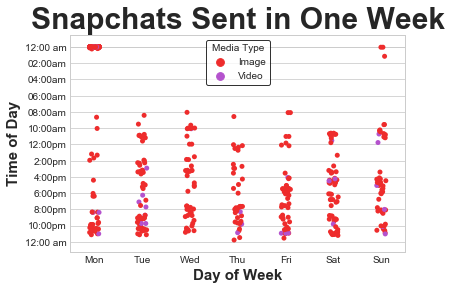

In [49]:
sea.set_style("whitegrid")
#Formatting dictionaries
pallete={"VIDEO":"#B452CD", "IMAGE":"#EE2C2C"}
titledict = {"fontsize":30, "fontweight":"bold"}
axisdict = {"fontsize":15, "fontweight":"bold"}
# matplotlib ax object that can be manipulated
g = sea.stripplot(x="Int Weekday", y="Minutes", hue="Media Type", data=snapsSentFrame, palette=pallete, jitter=True)
temp = g.set(yticks=timeTicks, yticklabels=timeStrings, xticklabels=weekdayStrings)
g.invert_yaxis()
# Have the temp values so strings aren't returned and printed
temp = g.set_title("Snapchats Sent in One Week", titledict)
temp = g.set_ylabel("Time of Day", axisdict)
temp = g.set_xlabel("Day of Week", axisdict)

legend = g.legend(title="Media Type", edgecolor="black", frameon=True)
legend.get_texts()[0].set_text("Image")
legend.get_texts()[1].set_text("Video")